# Data Analysis and Visualisation &mdash; Lab 02

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from setuptools.command.rotate import rotate

plt.style.use("ggplot")
plt.rcParams.update({
    "font.size": 12,
})

## Problem 1

In [10]:
statcounter_ww = pd.read_csv("../data/linux-adoption/StatCounter_Worldwide.csv", parse_dates=["Date"])
statcounter_vn = pd.read_csv("../data/linux-adoption/StatCounter_Viet+Nam.csv", parse_dates=["Date"])

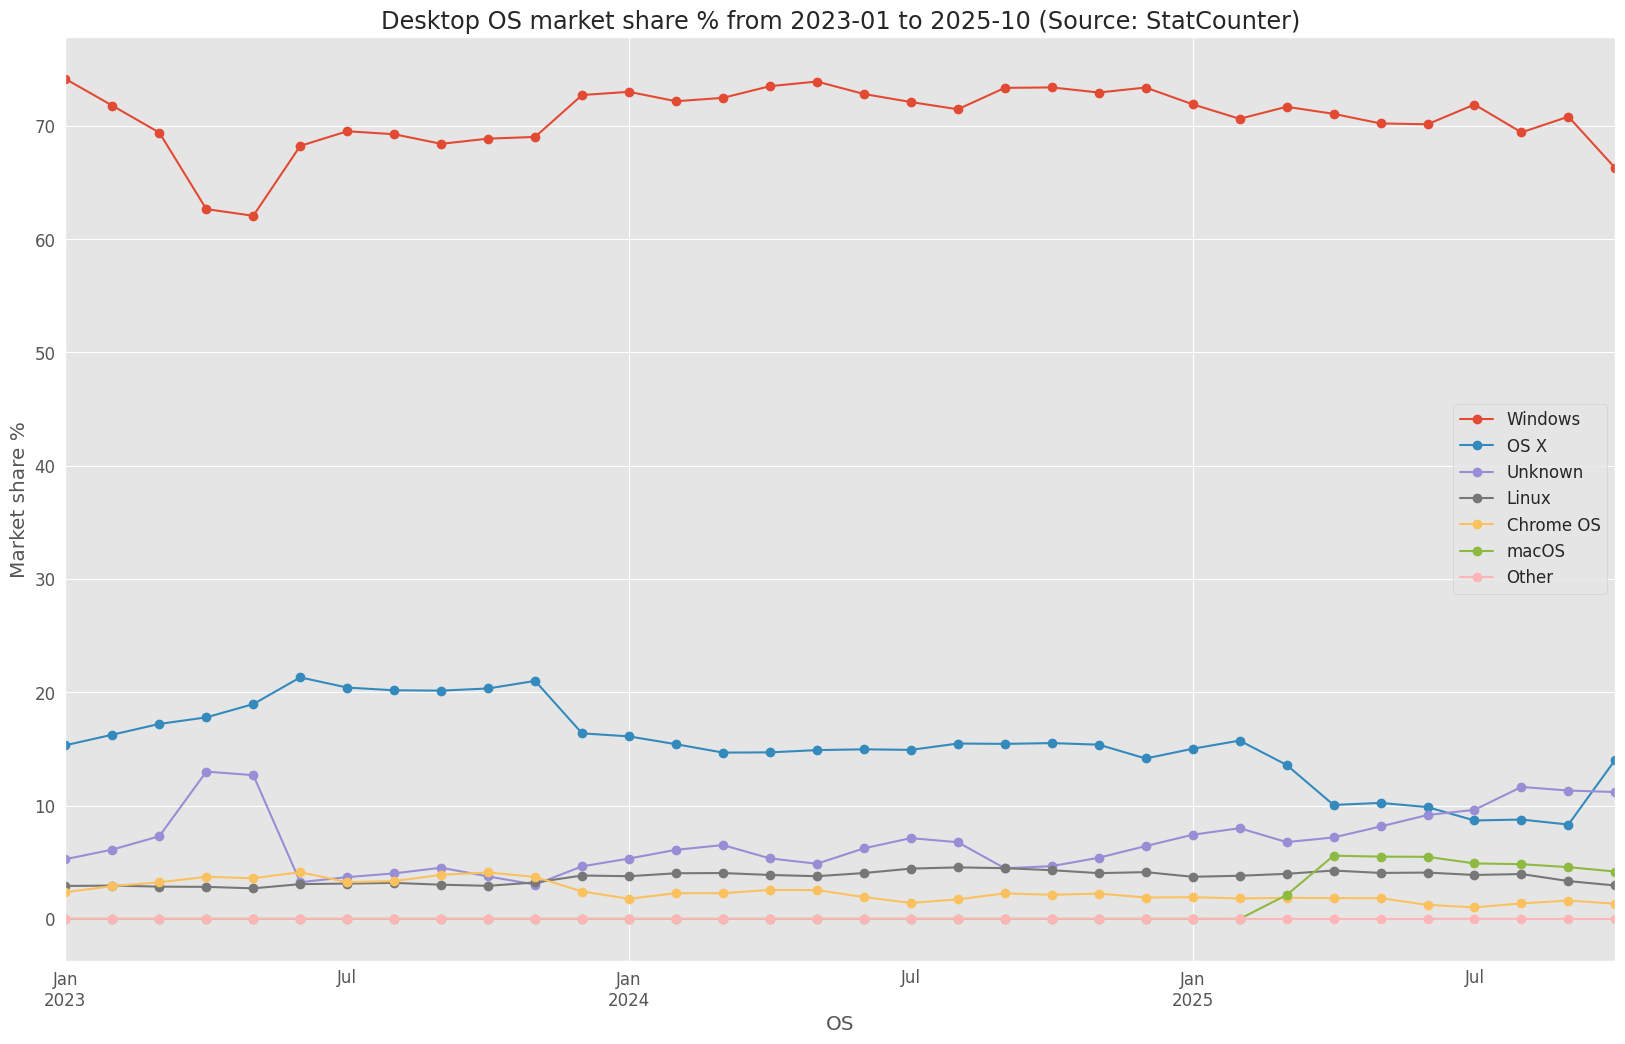

In [11]:
statcounter_ww.plot.line(x="Date", marker="o", figsize=(20, 12))

plt.title("Desktop OS market share % from 2023-01 to 2025-10 (Source: StatCounter)")

plt.xlabel("OS")
plt.ylabel("Market share %")

plt.show()

In [19]:
steam_hw_survey = pd.read_csv("../data/linux-adoption/Steam+HW+Survey_Platform+Versions.csv", parse_dates=["date"])

In [20]:
shs_linux = steam_hw_survey[steam_hw_survey["platform"] == "linux"]

shs_linux.tail()

,date,platform,category,name,change,percentage
647,2025-10-01,linux,Linux Version,Linux Mint 22.2 64 bit,0.0665,0.0665
648,2025-10-01,linux,Linux Version,Other,-0.0428,0.1804
649,2025-10-01,linux,Linux Version,Pop!_OS 22.04 LTS 64 bit,-0.0004,0.0193
650,2025-10-01,linux,Linux Version,Ubuntu 24.04.3 LTS 64 bit,0.0370,0.0370
651,2025-10-01,linux,Linux Version,Ubuntu Core 22 64 bit,0.0055,0.0455


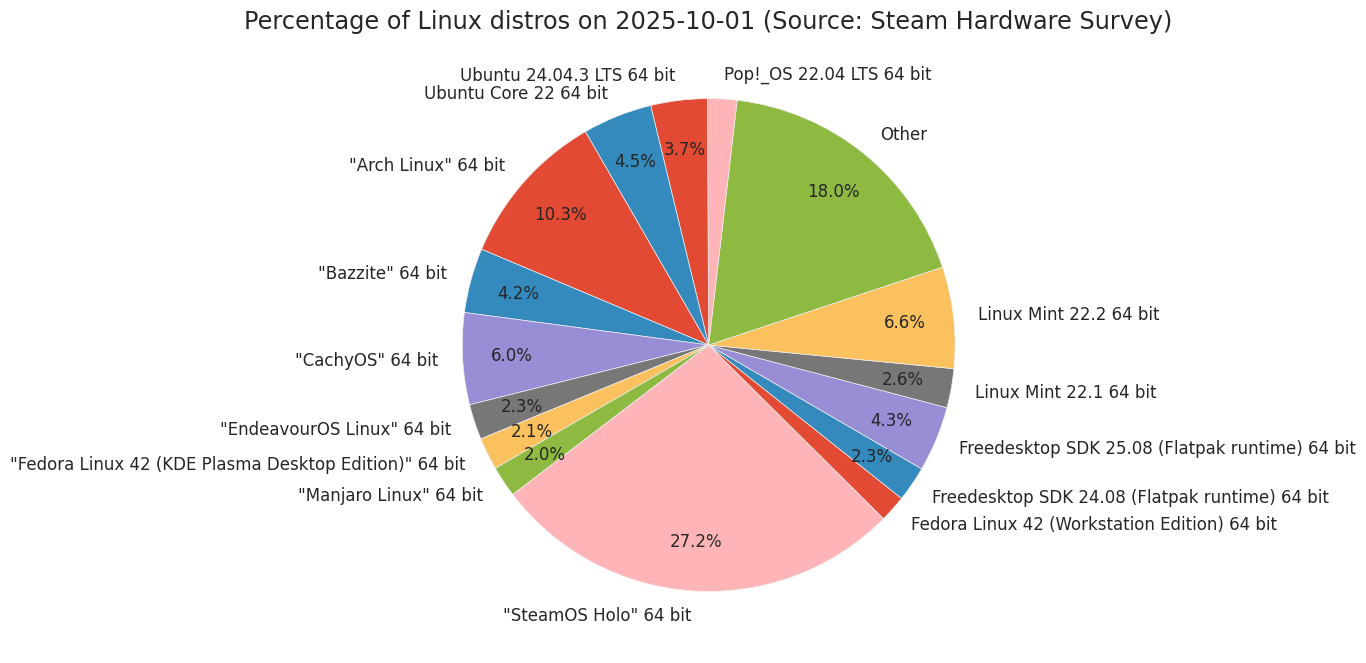

In [68]:
shs_linux[shs_linux["date"] == "2025-10-01"].set_index("name").plot.pie(
    y="percentage",
    autopct=lambda pct: f"{pct:.1f}%" if pct > 2 else "",
    figsize=(8, 8),
    startangle=120,
    pctdistance=0.8,
)

plt.title("Percentage of Linux distros on 2025-10-01 (Source: Steam Hardware Survey)")

plt.legend().remove()
plt.ylabel("")

plt.show()

In [13]:
distrowatch_phr = pd.read_csv("../data/linux-adoption/DistroWatch_HPD.csv")

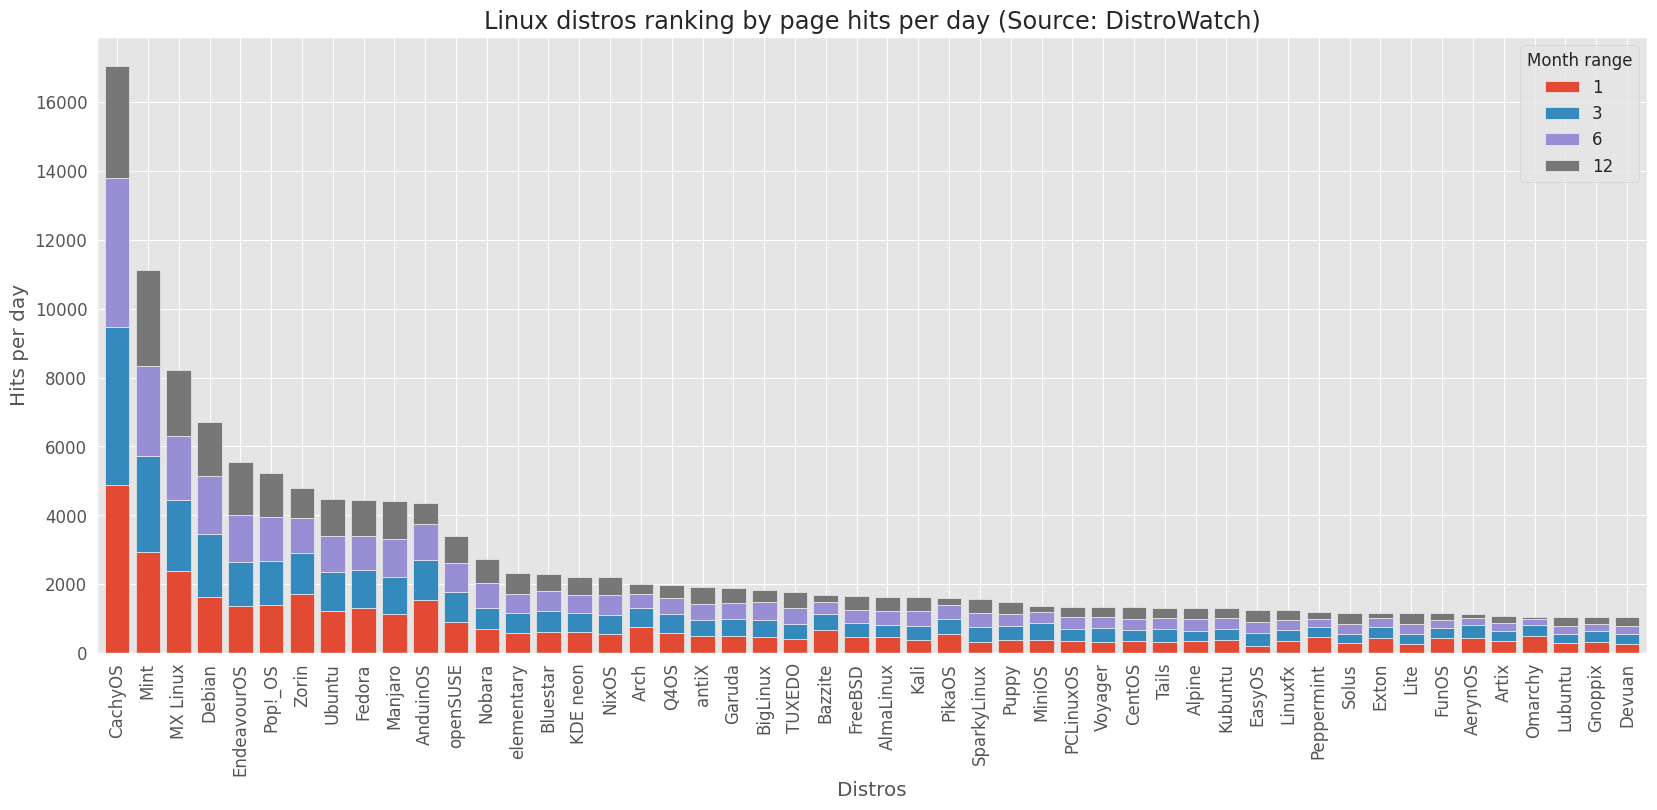

In [14]:
distrowatch_phr \
    .pivot_table(
        index="distro",
        columns="month_range",
        values="hits_per_day",
        aggfunc="sum",
    ).reset_index() \
    .assign(avg_hpd=lambda d: d.drop(columns="distro").mean(axis=1)) \
    .sort_values("avg_hpd", ascending=False).drop(columns="avg_hpd").set_index("distro").head(50) \
    .plot.bar(stacked=True, width=0.8, figsize=(20, 8))

plt.title("Linux distros ranking by page hits per day (Source: DistroWatch)")

plt.xlabel("Distros")
plt.ylabel("Hits per day")

plt.legend(title="Month range")

plt.show()

## Problem 2

In [7]:
coffee_chains = ["Highlands+Coffee", "Phuc+Long+Coffee", "Starbucks"]
cities = ["Hanoi", "Ho+Chi+Minh+City"]

dfs = {}

for chain in coffee_chains:
    for city in cities:
        key = f"{chain}_{city}"
        path = f"../data/coffee-chains/{chain}_{city}.csv"

        df = pd.read_csv(path)

        group_cols = [col for col in df.columns if col != "info"]
        df = df.groupby(group_cols, as_index=False).first()

        dfs[key] = df

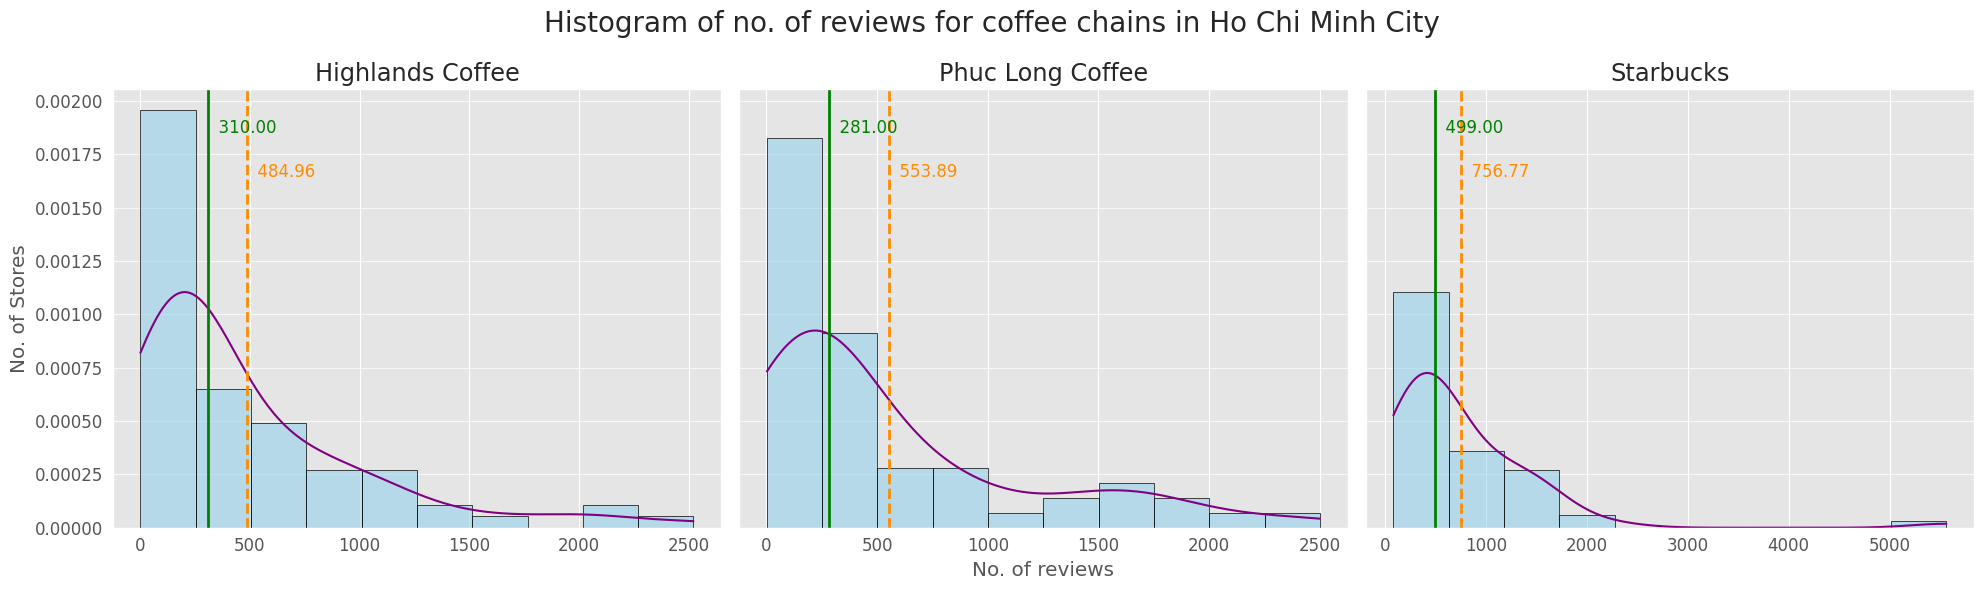

In [8]:
city = "Ho+Chi+Minh+City"

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for i, chain in enumerate(coffee_chains):
    df = dfs[f"{chain}_{city}"]

    num_of_reviews_mean = df["num_of_reviews"].mean()
    num_of_reviews_median = df["num_of_reviews"].median()

    sns.histplot(df["num_of_reviews"], bins=10, kde=True, stat="density", color="skyblue", edgecolor="black", ax=axes[i])

    axes[i].axvline(num_of_reviews_mean, color="darkorange", linestyle="dashed", linewidth=2)
    axes[i].text(num_of_reviews_mean, axes[i].get_ylim()[1] * 0.8, f"  {num_of_reviews_mean:.2f}", color="darkorange")

    axes[i].axvline(num_of_reviews_median, color="green",  linewidth=2)
    axes[i].text(num_of_reviews_median, axes[i].get_ylim()[1] * 0.9, f"  {num_of_reviews_median:.2f}", color="green")

    axes[i].grid(axis="y", alpha=0.7)
    axes[i].lines[0].set_color("purple")

    axes[i].set_title(chain.replace("+", " "))

    axes[i].set_xlabel("No. of reviews" if i == 1 else "")
    if i == 0:
        axes[i].set_ylabel("No. of Stores")

fig.suptitle("Histogram of no. of reviews for coffee chains in Ho Chi Minh City", fontsize=20)
plt.tight_layout()

plt.show()

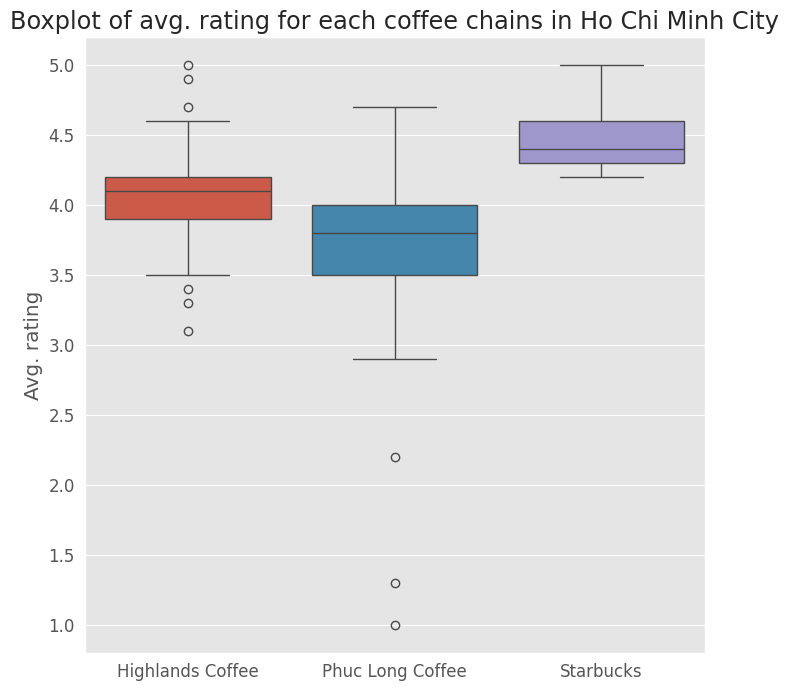

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

city = "Ho+Chi+Minh+City"

box_df = []
for chain in coffee_chains:
    key = f"{chain}_{city}"

    box_df.append(dfs[key].copy())
    box_df[-1]["chain"] = chain.replace("+", " ")

box_df = pd.concat(box_df).melt(
    id_vars=["chain"],
    value_vars=["avg_rating"],
    value_name="Avg. rating",
)

plt.figure(figsize=(8, 8))

sns.boxplot(data=box_df, x="chain", y="Avg. rating", hue="chain")

plt.title("Boxplot of avg. rating for each coffee chains in Ho Chi Minh City")

plt.xlabel("")

plt.show()

In [89]:
import folium
from folium.plugins import HeatMap

colour_palettes = {
    "Highlands+Coffee": {
        0.2: "#6b2e1e",
        0.4: "#9c3e2b",
        0.6: "#c45a32",
        0.8: "#e88c4a",
        1.0: "#f9c784",
    },
    "Starbucks": {
        0.2: "#1e3932",
        0.4: "#00754a",
        0.6: "#00b57d",
        0.8: "#a7e0c2",
        1.0: "#f5f5dc",
    },
    "Phuc+Long+Coffee": {
        0.2: "#3c1361",
        0.4: "#5e2b97",
        0.6: "#7e57c2",
        0.8: "#b39ddb",
        1.0: "#ede7f6",
    },
}

city = "Ho+Chi+Minh+City"

m = folium.Map(
    location=[10.7769, 106.7009],
    zoom_start=12,
    tiles="CartoDB positron",
)

for chain in coffee_chains:
    chain_df = dfs[f"{chain}_{city}"]
    HeatMap(
        chain_df[["lat", "long"]].values,
        radius=10,
        blur=5,
        gradient=colour_palettes[chain],
    ).add_to(m)

m

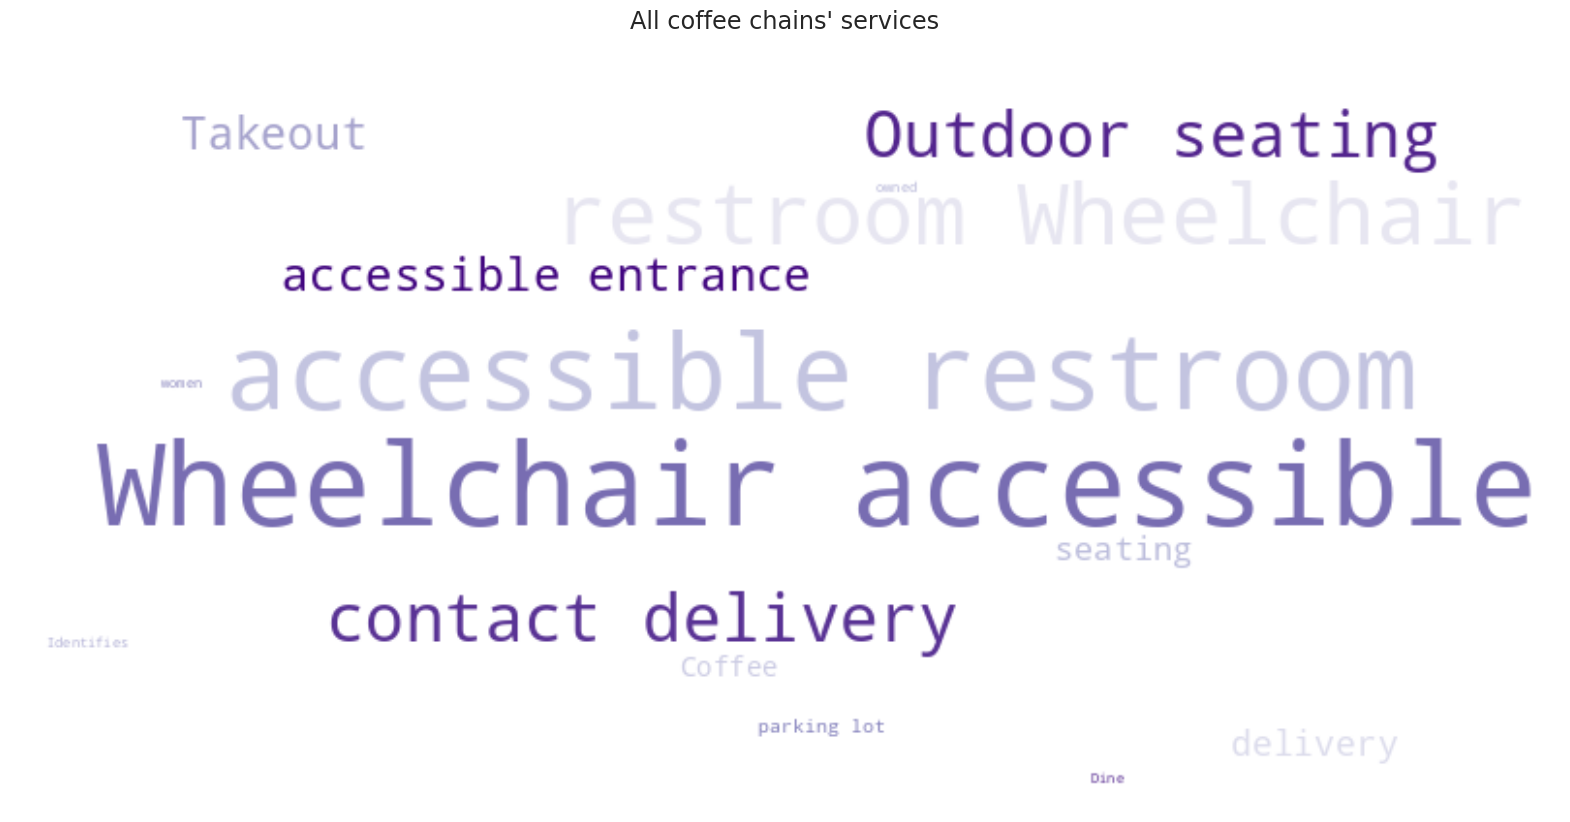

In [105]:
from wordcloud import WordCloud

text = " ".join([" ".join(df["info"]) for df in dfs.values()])
wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Purples",
).generate(text)

plt.figure(figsize=(20, 12))
plt.imshow(wc, interpolation="bilinear")

plt.title("All coffee chains' services")
plt.axis("off")

plt.show()